<a href="https://colab.research.google.com/github/AguaClara/aide_design_specs/blob/validation/validation/LFOM_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip install aguaclara
!pip install sklearn
!pip install matplotlib
!pip install numpy

# Welcome to the LFOM Validation Example!
I'll try to walk through the LFOM as an example of what the Python validation tool will do. This will assume the variables have already been parsed from 
Onshape using the functions ins [parse.py](https://github.com/AguaClara/aide_design_specs/blob/master/aide_doc/form_submit/templates/docs/parse.py)

## Imports and Defining Variables
First, I'll define the variables which are output by the Onshape model, as
well as the inputs which we are trying to "calculate back to." As mentioned above, these values would be obtained through functions in `parse.py`,
but to keep the example simple I will hardcode them. Pint will be imported to
add units to the variables.

In [52]:
# import core aguaclara pkg functions
import aguaclara.core.constants as con
import aguaclara.core.physchem as pc
from aguaclara.design.lfom import LFOM
from aguaclara.core.units import u

# import numpy for arrays
import numpy as np

# define the inputs to the Onshape model
q = 10 * u.L / u.s
temp = 21 * u.degC

# define variables that will be output by Onshape
hl = 0.2 * u.m  # head loss
d_orifices = 0.016 * u.m  # diameter of orifices
b_rows = 0.017 * u.m  # space between rows
n_orifices = [17, 4, 6, 3, 4, 3, 3, 3, 3, 2, 3, 1]  # number of orifices per row
# height of the center of each row from the bottom of the bottom row
h_orifices = [0.0079375, 0.02467613636363637, 0.04141477272727274, 
              0.0581534090909091, 0.07489204545454548, 0.09163068181818185, 
              0.1083693181818182, 0.1251079545454546, 0.14184659090909096,
              0.15858522727272734, 0.1753238636363637, 0.19206250000000008] * u.m 

# set an acceptable tolerance 
# (I'll have to think harder about what this is in the future, for now I just picked 5%)
tol = 0.05

## Calculate the Onshape Model's Inputs
What exactly gets calculated will vary widely depending on the component. For each one, some basic checks can be made based on reversing calculations in the [aguaclara package](https://github.com/AguaClara/aguaclara)

Because there are multiple valid design algorithms for the LFOM, the pipe 
and orifices can have different diameters, leading to a different number of
orifices in each row. Therefore, only the design flow rate can be confirmed.
Fitting the flow rate at each row to a linear curve is sufficient to validate
the design.

In the case of the LFOM, we'll use this equation to determine the flow rates:


In [53]:
def flow_lfom_vert(height):
    """Returns the flow through the LFOM as a function of height"""
    flow = pc.flow_orifice_vert(d_orifices, height - h_orifices, con.VC_ORIFICE_RATIO)*n_orifices
    return (sum(flow)).to(u.L/u.s)


However, we want to make sure to include the tolerance, so remembering that
the percent error equation is: 

`% error = ((approx - actual) / actual) * 100`,
we can do the following:

In [93]:
# check this is within tolerance of design flow rate
q_calc = flow_lfom_vert(h_orifices[-1] + 0.5 * d_orifices) 
assert tol > (q_calc - q) / q
assert -tol < (q_calc - q) / q
print("The expected flow rate, {!s}, very close to the one calculated by this validation code, {!s}.".format(q, q_calc))

The expected flow rate, 10 liter / second, very close to the one calculated by this validation code, 10.36 liter / second.


Next, let's try a slightly more complicated validation: checking that the flow 
rates fit a linear curve.

The R^2 value for the LFOM flow rates was 0.9998586066038334 



/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


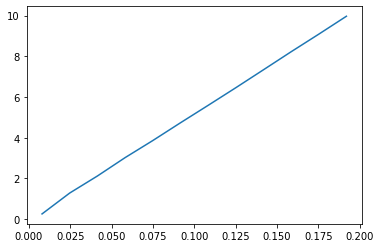

In [92]:
# create a list of flow rates
flows = []

for h in h_orifices:
  flows.append(flow_lfom_vert(h).magnitude)

flows = flows * u.L / u.s

# check their linearity
import numpy as np

# https://www.kite.com/python/answers/how-to-calculate-r-squared-with-numpy-in-python#:~:text=corrcoef(x%2Cy)%20with,coefficient%20of%20determination%2C%20R%20squared
r2 = np.corrcoef(h_orifices.magnitude, flows.magnitude)[0,1]**2
print('The R^2 value for the LFOM flow rates was', r2, '\n')

# we can also show this graphically
# (this is useful for manual validation, but R^2 is needed for automation)
import matplotlib.pyplot as plt

plt.plot(h_orifices, flows)
plt.show()

It's good to validate with multiple inputs, so here's another example:

In [95]:
# redefine the inputs from this design challenge:
# https://colab.research.google.com/github/AguaClara/CEE4520/blob/master/DC%20Solutions%202017/Jupyter%20Notebooks/DC_Flow_Control_and_Measurement_Solution.ipynb#scrollTo=azQlMZSDE6jB
q = 31 * u.L / u.s
hl = 0.2 * u.m  # head loss
lfom = LFOM(q=q, hl=hl)

# define variables that were output in above DC
d_orifices = 0.015 * u.m  # diameter of orifices
b_rows = 0.2 * u.m  # space between rows
n_orifices = [ 43, 43, 14, 15, 13, 12, 11, 11, 9, 10] # number of orifices per row
# height of the center of each row from the bottom of the bottom row
h_orifices = [0.75, 2.75, 4.75, 6.75, 8.75, 10.75, 12.75, 14.75, 16.75, 18.75] * u.cm 

In [96]:
# check this is within tolerance of design flow rate
q_calc = flow_lfom_vert(h_orifices[-1] + 0.5 * d_orifices) 
assert tol > (q_calc - q) / q
assert -tol < (q_calc - q) / q
print("The expected flow rate, {!s}, very close to the one calculated by this validation code, {!s}.".format(q, q_calc))


The expected flow rate, 31 liter / second, very close to the one calculated by this validation code, 30.73 liter / second.


The R^2 value for the LFOM flow rates was 0.9995476782948031 



/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


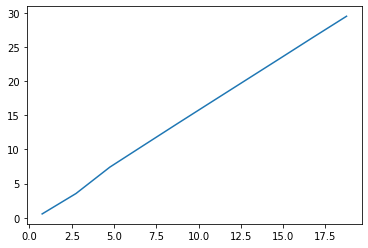

In [97]:
# create a list of flow rates
flows = []

for h in h_orifices:
  flows.append(flow_lfom_vert(h).magnitude)

flows = flows * u.L / u.s

# check their linearity
import numpy as np

# https://www.kite.com/python/answers/how-to-calculate-r-squared-with-numpy-in-python#:~:text=corrcoef(x%2Cy)%20with,coefficient%20of%20determination%2C%20R%20squared
r2 = np.corrcoef(h_orifices.magnitude, flows.magnitude)[0,1]**2
print('The R^2 value for the LFOM flow rates was', r2, '\n')

# we can also show this graphically
# (this is useful for manual validation, but R^2 is needed for automation)
import matplotlib.pyplot as plt

plt.plot(h_orifices, flows)
plt.show()